## Introduction

The Titanic is now infamous as a shipwreck at the beginning of the 20th century. Many passengers lost their lives when the ship went down, cementing this as a tragic piece of history. We can attempt to understand what it was like in those final moments from the stories of those who survived, our exploration of the wreckage, and through our use of the records available to us. 

In this report, we will be focusing on an analysis of the passenger manifest to get a picture of who survived the wreck. The guiding question is "Who had a better chance of surviving the wreck?"

While our focus will be on the numbers, we should be aware that what we're building is a big picture understanding of what happened. We'll be accessing a story of tragedy through modern data-driven means. 

### Tools

Our tools will be the language Python and it's data analysis libraries. We'll make use of pandas, numpy, matplotlib (with seaborn), and some statistical tests from scipy and statsmodels.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison

%pylab inline

titanic = pd.read_csv('titanic_data.csv')

Populating the interactive namespace from numpy and matplotlib


Our alpha level for our statistical tests will be 0.05.

### The Dataset

The dataset originates from a learning competition on Kaggle, [*Titanic: Machine Learning from Disaster*](https://www.kaggle.com/c/titanic). Since this analysis is mainly exploratory, our focus is on the provided train.csv file and doesn't include test.csv. This dataset is already well-organized and formatted, and doesn't require much cleaning. 

Here's what the dataset looks like.

In [9]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
print("The number of rows in the dataset:",len(titanic),".")

The number of rows in the dataset: 891 .


The variables of interest will be Survived, Pclass, Sex, Age, Parch, Fare. The values of some of these variables aren't entirely obvious. Survived is a binary entry denoting whether the passenger survived the ship wreck with 1 denoting survival. Pclass is the passenger class, which can be used as a proxy for the wealth of the passenger, with 1st as the highest and 3rd as the lowest. Fare can also serve that purpose. Parch is the number of parents/children aboard. Of the variables of interest for analysis, only Age has missing values. 

In [4]:
titanic.isnull().sum()[titanic.isnull().sum() > 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

Age is missing 177 values, which is a significant proportion of the 891 rows in the dataset. Given the other variables in the dataset, there doesn't seem to be any reliable way to estimate the age for passengers where it is missing, and so when Age is used in calculations, the missing values will be omitted. This is handled either implicitly by filtering with a numerical comparison, which returns False for NaN's regardless of the comparison, or explicitly by setting parameters in function calls.

Throughout our analysis we will occasionally add columns to the dataset, where each value in the column is a result of aggregating data on that row. These alterations will be detailed as they come up.

## Analysis

### Initial Exploration

To start our calculations, we'll compute the baseline survival rate.

In [5]:
baseline_survival = titanic['Survived'].mean()
baseline_survival

0.3838383838383838

Our goal is to find factors that influenced survival. To start, we can compute correlation coefficients with the Survived varibles and other numerical variables Survived to get an idea of basic hypotheses we can test.

In [6]:
titanic.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

The correlations that stand out in this list are Pclass and Fare. These both serve as relative measures of the wealth of the passenger.

We can also look at differences in means of various variables if we first group by Survived.

In [7]:
titanic.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


We see again what looks like differences in survival for Pclass and Fare, and maybe Age and Parch. Since Pclass and Fare are both proxies for the wealth of the passenger, but Pclass is discrete, our analysis will focus on this variable rather than Fare. Also, the analysis will not look at Parch, assuming that it's possible relationship to survival is mostly due to being somewhat conflated with Age and possibly Sex. 

Finally as part of the initial analysis we would like to look at possible differences in survival between genders. We can get an idea of the difference by grouping by genders and looking at the mean survival rate.

In [8]:
titanic.groupby('Sex').mean()['Survived']

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

There looks to be a very stark difference between male and female survival rates and so we'll also look at this closer.

### Passenger Class

We'll first focus on Pclass. If we group by Pclass and plot the means:

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


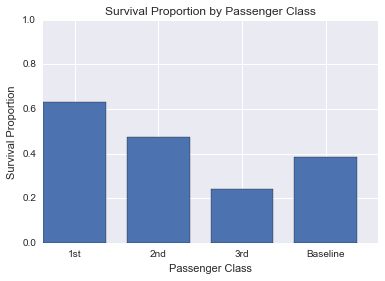

In [9]:
means_by_pclass = titanic.groupby('Pclass').mean()['Survived']
print(means_by_pclass)

# Append the baseline_survival rate to the means list for plotting
means_by_pclass = means_by_pclass.append(pd.Series([baseline_survival]))

# Prepare parameters for plotting
N = len(means_by_pclass) 
fig, ax = plt.subplots()

bar_width = 0.75
left_locs = np.arange(N)

ax.bar(left_locs, means_by_pclass, bar_width)

ax.set_ylabel('Survival Proportion')
ax.set_xlabel('Passenger Class')
ax.set_title('Survival Proportion by Passenger Class')
ax.set_xticks(left_locs + bar_width/2)
ax.set_xticklabels(('1st', '2nd', '3rd', 'Baseline'))
silent = plt.ylim([0,1])

These means all seem to differ from the baseline survival rate. An interesting question is whether these deviations are statistically significant. We'll perform a t-test on each subset to see if the deviations from the baseline are significant. 

In [19]:
survival_by_pclass = titanic.groupby('Pclass')['Survived']

# Perform one sample t-tests of each Pclass against baseline_survival as the population mean.
ttest_1_pclass = ttest_1samp(survival_by_pclass.get_group(1), baseline_survival, nan_policy='omit')
ttest_2_pclass = ttest_1samp(survival_by_pclass.get_group(2), baseline_survival, nan_policy='omit')
ttest_3_pclass = ttest_1samp(survival_by_pclass.get_group(3), baseline_survival, nan_policy='omit')

print("The P value for the 1 sample t-test comparing the mean survival rate for the 1st passenger class and the baseline is:",ttest_1_pclass.pvalue,".")
print("The P value for the 1 sample t-test comparing the mean survival rate for the 2nd passenger class and the baseline is:",ttest_2_pclass.pvalue,".")
print("The P value for the 1 sample t-test comparing the mean survival rate for the 3rd passenger class and the baseline is:",ttest_3_pclass.pvalue,".")

The P value for the 1 sample t-test comparing the mean survival rate for the 1st passenger class and the baseline is: 2.06960388843e-12 .
The P value for the 1 sample t-test comparing the mean survival rate for the 2nd passenger class and the baseline is: 0.0168903819463 .
The P value for the 1 sample t-test comparing the mean survival rate for the 3rd passenger class and the baseline is: 1.10691724393e-12 .


Thus we see that each difference from the baseline is statistically significant, even for the 2nd passenger class, which lies relatively closely to the baseline. Another important question is whether these groups differ from each other significantly. Let's perform a F-test.

In [20]:
# Perform an F-test on the mean survival rates of each Pclass.
ftest_pclass = f_oneway(survival_by_pclass.get_group(1), survival_by_pclass.get_group(2), survival_by_pclass.get_group(3))
print("The P value for the F-test comparing the mean survival rate each passenger class is",ftest_pclass.pvalue,".")

The P value for the F-test comparing the mean survival rate each passenger class is 2.18324741512e-24 .


The F-test reveals that at least two of the groups differ significantly. We can perform a Tukey's test to see which differ.

In [9]:
# Use multicomparison from statsmodels to perform Tukey's test for Pclass groups
multicomp_pclass = MultiComparison(titanic['Survived'], titanic['Pclass'])
print(mod.tukeyhsd())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2    -0.1568  -0.2647 -0.0489  True 
  1      3    -0.3873  -0.4751 -0.2994  True 
  2      3    -0.2305  -0.3234 -0.1375  True 
---------------------------------------------


As it turns out, each group is significantly different from each other. We can conclude that each passenger classes had different survival rates.

This suggests that being in a higher class offered a better chance of survival. What story does this tell? Perhaps the better passenger classes were given priority on the limited lifeboats, or perhaps the way rooms were distributed around the boat put the more expensive rooms closer to lifeboats.

### Gender and Age

Similar to what we did with passenger class, we'll first look at the differences in survival rate by gender. 

In [27]:
# Perform an independent t-test comparing the gender groups
gender_groups = titanic.groupby('Sex')['Survived']
results_gender = ttest_ind(gender_groups.get_group('female'), gender_groups.get_group('male'), \
                           equal_var=False, nan_policy='omit')
print("The P value for the independent t-test comparing the mean survival rate for each gender is:",results_gender.pvalue,".")

The P value for the independent t-test comparing the mean survival rate for each gender is: 2.2836009226e-61 .


We see a highly significant difference in the survival rate of males and females, with the female mean greater than males.

As for age, any difference in survival might be easier to see if we split by children and adults, or those under 18 and those over 18.

In [38]:
# Group in titanic by using a mapping function on age which assigns people to either the under 18 or over 18 group
def assign_age_group(x):
    return "Under_18" if titanic['Age'].loc[x] < 18 else "Over_18"

age_groups = titanic.groupby(assign_age_group)['Survived']
age_groups.mean()

Over_18     0.361183
Under_18    0.539823
Name: Survived, dtype: float64

Thus, we see a difference in the survival rates of those under 18 and those over 18. Is this difference statistically significant?

In [28]:
results_age = ttest_ind(age_groups.get_group('Under_18'), age_groups.get_group('Over_18'), \
                        equal_var=False, nan_policy='omit')
print("The P value for the independent t-test comparing the mean survival rates of children and adults is:",results_age.pvalue,".")

The P value for the independent t-test comparing the mean survival rates of children and adults is: 0.000499467062727 .


Thus the difference is significant. The significantly higher survival rate of females vs males suggests that women and girls were given priority in boarding lifeboats. And similarly, the higher survival rates of the under 18 group suggests that children were given priority in boarding lifeboats.

What if we look a little bit closer at gender and age together? Were girls more likely to survive than boys and women more likely than men?

          Sex   
Over_18   female    0.752896
          male      0.165703
Under_18  female    0.690909
          male      0.396552
Name: Survived, dtype: float64


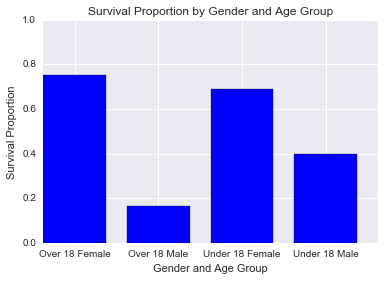

In [39]:
# Group by the previous mapping function and also by the Sex column
gender_age_groups = titanic.groupby([assign_age_group, 'Sex'])['Survived']
print(gender_age_groups.mean())

# Prepare plotting parameters
means_by_gender_age = gender_age_groups.mean()

N = len(means_by_gender_age) 
fig, ax = plt.subplots()

bar_width = 0.75
left_locs = np.arange(N)

ax.bar(left_locs, means_by_gender_age, bar_width, label='Survived', color='blue')

ax.set_ylabel('Survival Proportion')
ax.set_xlabel('Gender and Age Group')
ax.set_title('Survival Proportion by Gender and Age Group')
ax.set_xticks(left_locs + bar_width/2)
silent = ax.set_xticklabels(('Over 18 Female', 'Over 18 Male', 'Under 18 Female', 'Under 18 Male'))
silent = plt.ylim([0,1])

Tentatively it looks like women and girls had about the same survival rate, which were both better than boys and men, while boys had better survival rates than men.

Let's make this more precise. First, we'll add another column to our dataframe to make grouping a little easier.

In [32]:
# Takes a row from the data frame and returns a string representing it's sex and age group pair
def sex_age_pair(row):
    if row['Sex'] == 'male' and row['Age'] < 18:
        return "M-C"
    elif row['Sex'] == 'male' and row['Age'] >= 18:
        return "M-A"
    elif row['Sex'] == 'female' and row['Age'] < 18:
        return "F-C"
    else:
        return "F-A"

# Apply the function to each row and assign the result to a new column in titanic
titanic['sex_age_pair'] = titanic.apply(lambda x: sex_age_pair(x), axis=1)

Now we can perform an F-test to see if there is any significant difference between the groups.

In [34]:
# Perform an F-test on the mean survival rates of each sex and age pair 
gender_age_groups = titanic.groupby('sex_age_pair')['Survived']
ftest_gender_age = f_oneway(gender_age_groups.get_group('M-C'), gender_age_groups.get_group('M-A'), 
                        gender_age_groups.get_group('F-C'), gender_age_groups.get_group('F-A'))
print("The P value for the F-test comparing the means of the sex and age pairs is:",ftest_gender_age.pvalue,".")

The P value for the F-test comparing the means of the sex and age pairs is: 2.75899055295e-32 .


The F-test suggests that at least two of the groupings are different, and so we can use Tukey's test.

In [24]:
# Perform a Tukey's test on the mean survival rates of each sex and age pair
multicomp_sex_age = MultiComparison(titanic['Survived'], titanic['sex_age_pair'])
print(mod.tukeyhsd())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 F-A    F-C     0.14   -0.0263  0.3062 False 
 F-A    M-A   -0.3737  -0.4564  -0.291  True 
 F-A    M-C   -0.1544  -0.3168  0.0081 False 
 F-C    M-A   -0.5137  -0.6796 -0.3478  True 
 F-C    M-C   -0.2944  -0.5114 -0.0774  True 
 M-A    M-C    0.2193   0.0572  0.3815  True 
---------------------------------------------


These results suggest that indeed women, girls, and boys survived at different rates from men, and further that girls had better survival rates than boys. This suggests that women and girls were given the highest priority, followed by boys and then finally by men.

### Gender, Age, and Passenger Class

Finally, let's see if we can find any significant differences if we group the data by all three variables. This will help get us a more nuanced picture. Perhaps we only saw the difference in survival for different passenger classes because of different demographics.

We'll plot a bar graph of the different survival rates, grouped first by the passenger class, then ordered within those groups as Over 18 Females, Over 18 Males, Under 18 Females, and Under 18 Males. The results in this section are more tentative since the complexity of the grouping results in some small sample sizes, particularly in the under 18 group in the 1st passenger class.

Pclass            Sex   
1       Over_18   female    0.976744
                  male      0.347458
        Under_18  female    0.875000
                  male      1.000000
2       Over_18   female    0.906250
                  male      0.082474
        Under_18  female    1.000000
                  male      0.818182
3       Over_18   female    0.486239
                  male      0.121711
        Under_18  female    0.542857
                  male      0.232558
Name: Survived, dtype: float64
Pclass            Sex   
1       Over_18   female     86
                  male      118
        Under_18  female      8
                  male        4
2       Over_18   female     64
                  male       97
        Under_18  female     12
                  male       11
3       Over_18   female    109
                  male      304
        Under_18  female     35
                  male       43
Name: Survived, dtype: int64


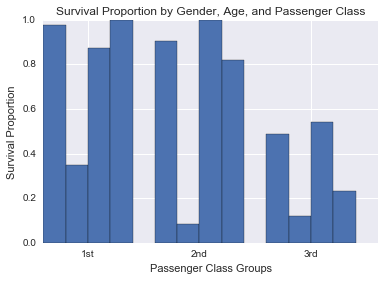

In [40]:
# Group by apply the mapping function for age as before, along with Pclass and Sex
gender_age_pclass_group = titanic.groupby(['Pclass', assign_age_group, 'Sex'])['Survived']
print(gender_age_pclass_group.mean())
print(gender_age_pclass_group.count())

# Prepare parameters for plotting
means_by_gender_age_pclass = gender_age_pclass_group.mean()

N = len(means_by_gender_age_pclass) 
fig, ax = plt.subplots()

bar_width = 0.2
left_locs = np.arange(N/3) # divide by 3 to set up 3 different plotting groups

# Plot each passenger class together and shift left_locations so as not to overlap
ax.bar(left_locs*bar_width, means_by_gender_age_pclass.loc[1], bar_width)
ax.bar(left_locs*bar_width + 1, means_by_gender_age_pclass.loc[2], bar_width)
ax.bar(left_locs*bar_width + 2, means_by_gender_age_pclass.loc[3], bar_width)

ax.set_ylabel('Survival Proportion')
ax.set_xlabel('Passenger Class Groups')
ax.set_title('Survival Proportion by Gender, Age, and Passenger Class')
ax.set_xticks([bar_width*2,bar_width*2 + 1,bar_width*2 + 2])
silent = ax.set_xticklabels(('1st', '2nd', '3rd'))

Both 1st and 2nd passenger class look very similar, but 3rd stands out as being lower across each sex and age pair, except possibly for over 18 males.

We'll define another function which will be used to map the rows of the dataframe to a value representing its sex, age group and passenger class triple.

In [42]:
# Take a row from the data frame, pass it to sex_age_pair from before and then append passenger class to the string
def sex_age_pclass_triple(row):
    if row['Pclass'] == 1:
        return sex_age_pair(row) + '-1st'
    elif row['Pclass'] == 2:
        return sex_age_pair(row) + '-2nd'
    else:
        return sex_age_pair(row) + '-3rd'

# Use sex_age_pclass_triple to define a new column in titanic    
titanic['sex_age_pclass_triple'] = titanic.apply(lambda x: sex_age_pclass_triple(x), axis=1)

We can now use the new column to perform an F-test.

In [44]:
# Perform an F-test on the mean survival rate of the data grouped by the triples
gender_age_pclass_groups = titanic.groupby('sex_age_pclass_triple')['Survived']
ftest_gender_age_pclass = f_oneway( gender_age_pclass_groups.get_group('M-C-1st'), gender_age_pclass_groups.get_group('M-A-1st'), \
                                    gender_age_pclass_groups.get_group('F-C-1st'), gender_age_pclass_groups.get_group('F-A-1st'), \
                                    gender_age_pclass_groups.get_group('M-C-2nd'), gender_age_pclass_groups.get_group('M-A-2nd'), \
                                    gender_age_pclass_groups.get_group('F-C-2nd'), gender_age_pclass_groups.get_group('F-A-2nd'), \
                                    gender_age_pclass_groups.get_group('M-C-3rd'), gender_age_pclass_groups.get_group('M-A-3rd'), \
                                    gender_age_pclass_groups.get_group('F-C-3rd'), gender_age_pclass_groups.get_group('F-A-3rd') )
print("The P value for the F-test comparing the means of the sex, age group and passenger class triples is:",ftest_gender_age_pclass.pvalue,".")

The P value for the F-test comparing the means of the sex, age group and passenger class triples is: 1.34577471331e-70 .


At least two of the groups are different. We'll conclude by running a Tukey's test to determine which passenger classes are different after grouping by sex and age groups. (The full results and code are reproduced in the appendix, since this test produces a 132 row table.)

This final Tukey test reveals some interesting differences. We see that the survival rate for the 3rd passenger class was significantly worse across every sex and age group pair. Perhaps the room placement for the 3rd passenger class put them at a significant disadvantage during the shipwreck. The only exceptions might be under 18 females in 1st class versus 3rd class and over 18 males in 2nd class vs 3rd class. The former could be due to the small sample size of under 18 females in 1st class decreasing the power of the test. 

The latter elucidates an interesting difference. Over 18 males in 1st and 2nd class is the only group which shows a significant difference between other sex and age group pair 1st and 2nd classes. This suggests that over 18 males in 1st class had some advantage in surviving the ship wreck.

## Conclusion

The data seems to corroborate the story of the Titanic shipwreck that we've heard in popular culture. Women and children seem like they were given preference over males. However, it has also revealed where that story is more nuanced. Even comparing young girls and boys, it looks like girls had a higher chance to survive. Being in 3rd class meant a worse chance for survival. And for some reason adults males in 1st class had significantly better survival chances than other adult males.

## Appendix: Full Tukey's Test Results for Gender/Age/Passenger Class

In [45]:
multicomp_sex_age_pclass = MultiComparison(titanic['Survived'], titanic['sex_age_pclass_triple'])
print(multicomp_sex_age_pclass.tukeyhsd())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
F-A-1st F-A-2nd -0.0099  -0.2085  0.1887 False 
F-A-1st F-A-3rd -0.5264  -0.6826 -0.3701  True 
F-A-1st F-C-1st  0.0432  -0.4363  0.5227 False 
F-A-1st F-C-2nd  0.1682   -0.23   0.5665 False 
F-A-1st F-C-3rd -0.2889  -0.5437 -0.0342  True 
F-A-1st M-A-1st -0.4606   -0.644 -0.2772  True 
F-A-1st M-A-2nd -0.7636  -0.9519 -0.5753  True 
F-A-1st M-A-3rd -0.6984  -0.8538 -0.5431  True 
F-A-1st M-C-1st  0.1682   -0.498  0.8344 False 
F-A-1st M-C-2nd -0.0136  -0.4278  0.4006 False 
F-A-1st M-C-3rd -0.5992  -0.8354  -0.363  True 
F-A-2nd F-A-3rd -0.5165   -0.695  -0.338  True 
F-A-2nd F-C-1st  0.0531  -0.4341  0.5403 False 
F-A-2nd F-C-2nd  0.1781  -0.2294  0.5856 False 
F-A-2nd F-C-3rd -0.2791   -0.548 -0.0101  True 
F-A-2nd M-A-1st -0.4508  -0.6535 -0.2481  True 
F-A-2nd M-A-2nd -0.7537  -0.9608 -0.5466  True 
F-A-2nd M-A-3rd -0.6886  -0.8663 -0.5